In [ ]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
# twinLab import
import twinlab as tl
tl.set_user("cyd@digilab.co.uk")
tl.set_api_key("")


          ====== TwinLab Client Initialisation ======
          Version     : 2.21.0
          User        : cyd@digilab.co.uk
          Server      : https://twinlab.digilab.co.uk/v3
          Environment : /Users/cyd/Desktop/twinLab/.env



<>:2: DeprecationWarning: invalid escape sequence '\s'
<>:2: DeprecationWarning: invalid escape sequence '\s'
/var/folders/rq/1dyk93h5027fx7s4mn1lpdqm0000gn/T/ipykernel_1858/2751358948.py:2: DeprecationWarning: invalid escape sequence '\s'
  df = pd.read_csv("results.csv",sep="\s+")


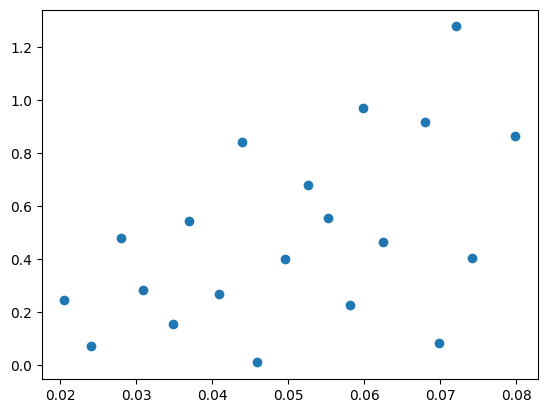

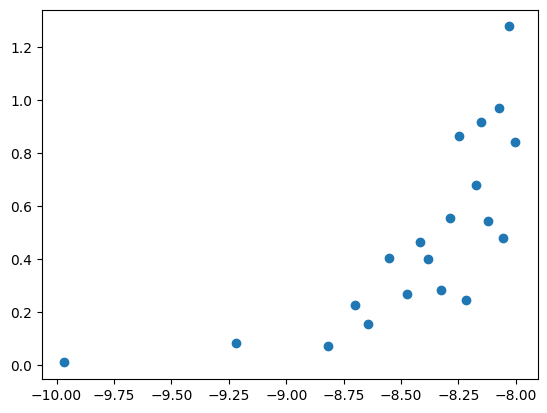

In [11]:
# read the training data from galaxy workflows
df = pd.read_csv("results.csv",sep="\s+")

df_input = pd.DataFrame({
    "solubility": df["solubility"][:20],
    "logdiffusivity":np.log10(df["diffusivity"][:20]),
    "p_out_grad":df["p_out_grad"][:20]

})

# plot the relationship between indevidual inputs and outputs
plt.scatter(df_input["solubility"],df_input["p_out_grad"])
plt.show()

plt.scatter(df_input["logdiffusivity"],df_input["p_out_grad"])
plt.show()

In [3]:
# Define the name of the dataset
dataset_id = "UoM_dataset"

# Intialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset
dataset.upload(df_input, verbose=True)

Dataframe is uploading.
Dataset successfully uploaded.


In [4]:
# Initialise emulator
emulator_id = "UoM_emulator"
emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
output_columns = ["p_out_grad"]
params = tl.TrainParams(
    train_test_ratio=0.75,
    estimator="gaussian_process_regression",

)

# Train the emulator using the train method
emulator.train(
    dataset=dataset,
    inputs=["logdiffusivity","solubility"],
    outputs=output_columns,
    params=params,
    verbose=True,
)

Emulator 'UoM_emulator' has begun training.
0:00:00: Job status: processing
0:00:02: Job status: processing
0:00:04: Job status: processing
0:00:07: Job status: processing
0:00:09: Job status: success
Training of emulator UoM_emulator is complete!


In [ ]:
# create grid for plotting predictions
npoints = 100

X, Y = np.meshgrid(np.linspace(np.min(df_input["logdiffusivity"]),np.max(df_input["logdiffusivity"]),npoints),
                    np.linspace(np.min(df_input["solubility"]),np.max(df_input["solubility"]),npoints))

df_test = pd.DataFrame({
    "logdiffusivity": X.flatten(),
    "solubility": Y.flatten(),
})

# predict on the input grid
df_pred,df_std = emulator.predict(df_test)


Job predict process ID: predict-frost-speckle-lunge
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:06: Job status: processing
0:00:08: Job status: processing
0:00:10: Job status: success
Mean predictions:
      p_out_grad
0       0.059515
1       0.057255
2       0.055459
3       0.054103
4       0.053160
...          ...
9995    1.126808
9996    1.154648
9997    1.180921
9998    1.205433
9999    1.227999

[10000 rows x 1 columns]
Standard deviation predictions:
      p_out_grad
0       0.146837
1       0.147577
2       0.149333
3       0.152021
4       0.155528
...          ...
9995    0.041035
9996    0.045850
9997    0.051051
9998    0.056601
9999    0.062465

[10000 rows x 1 columns]


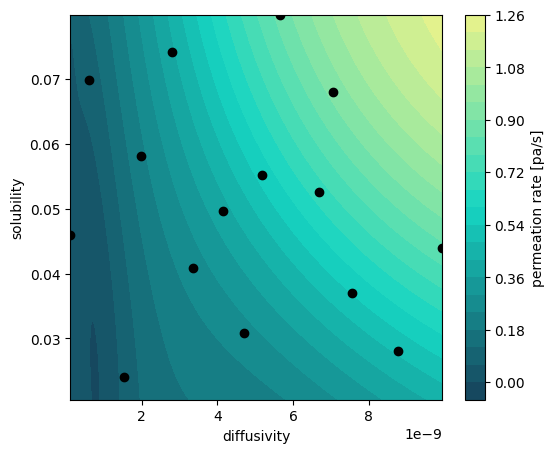

Text(0, 0.5, 'solubility')

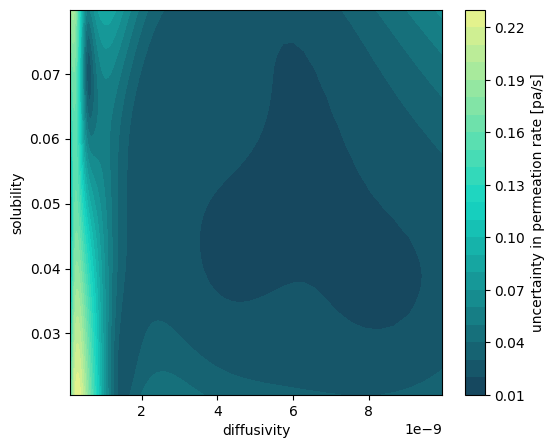

In [ ]:
# plot the outputs of the emulator
plt.figure(figsize=(6, 5))
colors = ["#16425B","#16D5C2","#EBF38B"]
custom_cmap = LinearSegmentedColormap.from_list("bah", colors) 
df_train = emulator.view_train_data()

# plot the tritium permeation rate
Z = np.array(df_pred["p_out_grad"]).reshape(npoints,npoints)
plt.contourf(10**X, (Y), Z, levels=20, cmap=custom_cmap)  # filled contours
plt.colorbar(label="permeation rate [pa/s]")
plt.scatter(10**df_train["logdiffusivity"],df_train["solubility"],color="black")
plt.xlabel("diffusivity")
plt.ylabel("solubility")
plt.show()

# plot the error in tritium permeation rate
plt.figure(figsize=(6, 5))

Zerr = np.array(df_std["p_out_grad"]).reshape(npoints,npoints)
plt.contourf(10**X, (Y), Zerr, levels=20, cmap=custom_cmap)  # filled contours
plt.colorbar(label="uncertainty in permeation rate [pa/s]")
plt.xlabel("diffusivity")
plt.ylabel("solubility")

In [ ]:
# validation step
# calculate mean standardized log loss
params = tl.ScoreParams(metric="MSLL", combined_score=True)
MSLLscore = emulator.score(params=params)

# calculate R squared
params = tl.ScoreParams(metric="R2", combined_score=True)
R2score = emulator.score(params=params)

print(MSLLscore,R2score)

# stopping criterion for active learning loop
if MSLLscore < -1.5 and R2score>0.95:
    print("model is good")

-2.547764850114361 0.9814148661184815
model is good


{'dataset': ',solubility,logdiffusivity,p_out_grad\n15,0.072145521,-8.031517051446064,1.277288\n16,0.0205579,-8.216811308924742,0.244876\n17,0.059850685,-8.072116589669292,0.971489\n18,0.062474116,-8.416801226031378,0.465452\n19,0.034798471,-8.645891560852599,0.154909\n', 'dataset_url': None}
Job predict process ID: predict-astonishing-ubiquitous-drizzle
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:06: Job status: processing
0:00:08: Job status: success
Mean predictions:
   p_out_grad
0    1.147622
1    0.250083
2    0.955066
3    0.470316
4    0.171351
Standard deviation predictions:
   p_out_grad
0    0.041541
1    0.031564
2    0.023520
3    0.021973
4    0.027763


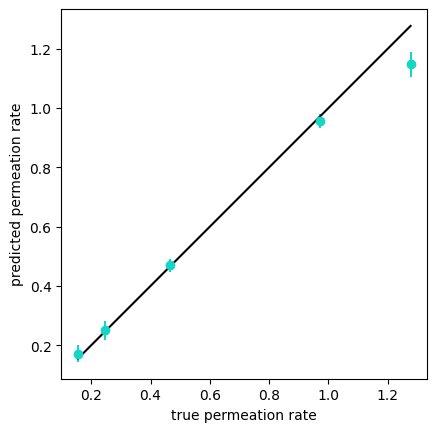

In [12]:
# create a validation plot, comparing predictions to true values for test data
test_data = emulator.view_test_data()
ytrue = test_data["p_out_grad"]
ypred,yprederr = emulator.predict(test_data)

fig,axs = plt.subplots(1,1)
plt.errorbar(ytrue,ypred["p_out_grad"],yerr=yprederr["p_out_grad"],linestyle="",marker="o",color="#16D5C2")
plt.plot([np.min(ytrue),np.max(ytrue)],[np.min(ytrue),np.max(ytrue)],color="black")
plt.xlabel("true permeation rate")
plt.ylabel("predicted permeation rate")
axs.set_aspect("equal")

In [15]:

df_obs = pd.DataFrame({'p_out_grad': [0.7]})
df_std = pd.DataFrame({'p_out_grad': [0.01]})
calib_results = emulator.calibrate(df_obs, df_std)


Job calibrate process ID: calibrate-persistent-brass-peony
0:00:00: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:12: Job status: processing
0:00:15: Job status: processing
0:00:18: Job status: processing
0:00:22: Job status: processing
0:00:26: Job status: processing
0:00:30: Job status: processing
0:00:35: Job status: processing
0:00:40: Job status: processing
0:00:46: Job status: processing
0:00:53: Job status: success
Calibration:
                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
logdiffusivity -7.745  1.094  -8.447   -7.285      0.226    0.180       9.0   
solubility     -0.246  1.356  -0.079    0.077      0.379    0.275      29.0   

                ess_tail  r_hat  
logdiffusivity       9.0   1.53  
solubility          11.0   1.40  
